In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [2]:
pip install imutils


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=edc19281605657d2082a7d5bbaf4a42ffb30dd677bef6fc389d8b47a84d9dcd7
  Stored in directory: c:\users\harshavardhanj\appdata\local\pip\cache\wheels\31\d0\2c\87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


In [3]:
from imutils import paths

In [4]:
imagePaths = sorted(list(paths.list_images("C:/Users/harshavardhanj/Desktop/Citrus/dataset/train")))

# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)
    
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

3208 images (3772.61MB)


In [5]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(3208, 224, 224, 3)


In [6]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 4 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. blackspot
2. canker
3. fresh
4. grenning


In [7]:
def MobileNetV2_model(learning_rate, input_shape,class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False
   
    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

In [8]:

bs = 32
lr = 0.0001
size = (224, 224)
shape = (224,224, 3) 
epochs = 10
class_number = 4

In [9]:
model = MobileNetV2_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

9406464/9406464 [==============================] - 2s 0us/step


In [10]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

In [11]:
# Assuming you have already split your data into trainX, testX, trainY, and testY
history = model.fit(trainX, trainY, batch_size=32, epochs=20, validation_data=(testX, testY))

Epoch 1/20
81/81 [==============================] - 98s 1s/step - loss: 0.7846 - accuracy: 0.8203 - val_loss: 0.2844 - val_accuracy: 0.9159
Epoch 2/20
81/81 [==============================] - 73s 907ms/step - loss: 0.2214 - accuracy: 0.9388 - val_loss: 0.2946 - val_accuracy: 0.9424
Epoch 3/20
81/81 [==============================] - 80s 988ms/step - loss: 0.1438 - accuracy: 0.9556 - val_loss: 0.2976 - val_accuracy: 0.9439
Epoch 4/20
81/81 [==============================] - 75s 933ms/step - loss: 0.1506 - accuracy: 0.9521 - val_loss: 0.1300 - val_accuracy: 0.9564
Epoch 5/20
81/81 [==============================] - 88s 1s/step - loss: 0.1093 - accuracy: 0.9653 - val_loss: 0.1097 - val_accuracy: 0.9688
Epoch 6/20
81/81 [==============================] - 92s 1s/step - loss: 0.1038 - accuracy: 0.9692 - val_loss: 0.4039 - val_accuracy: 0.9439
Epoch 7/20
81/81 [==============================] - 79s 973ms/step - loss: 0.0814 - accuracy: 0.9747 - val_loss: 0.1486 - val_accuracy: 0.9611
Epoch 8/

In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
21/21 [==============================] - 18s 739ms/step
              precision    recall  f1-score   support

   blackspot       1.00      0.96      0.98       235
      canker       0.97      1.00      0.98       250
       fresh       1.00      1.00      1.00        86
    grenning       1.00      1.00      1.00        71

    accuracy                           0.98       642
   macro avg       0.99      0.99      0.99       642
weighted avg       0.98      0.98      0.98       642



F1 Score: 0.9844114642848913
Precision: 0.9848034695898645
Recall: 0.9844236760124611


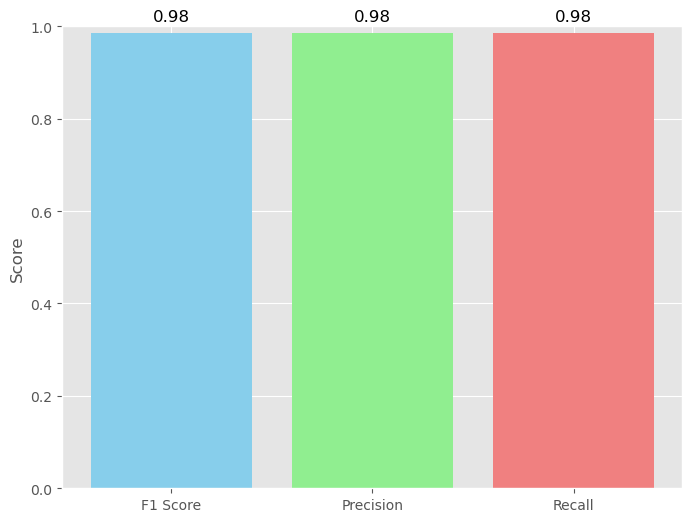

In [17]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already made predictions and have true labels
# predIdxs = np.argmax(predictions, axis=1)  # Already done in your code
# testY = true labels (ground truth)

# Compute F1 score, precision, and recall
f1 = f1_score(testY.argmax(axis=1), predIdxs, average='weighted')
precision = precision_score(testY.argmax(axis=1), predIdxs, average='weighted')
recall = recall_score(testY.argmax(axis=1), predIdxs, average='weighted')

# Print the metrics
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Create a bar graph to visualize the metrics
metrics = ['F1 Score', 'Precision', 'Recall']
values = [f1, precision, recall]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral'])

plt.ylabel("Score")
plt.ylim(0, 1)  # Set y-axis range between 0 and 1

# Add text labels with the exact values above each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=12)

plt.show()


In [14]:
print("[INFO] saving orange detector model...")
model.save("citrus_MobileNetV2.model", save_format="h5")
model.save("citrus_MobileNetV2tf.model", save_format="tf")


[INFO] saving orange detector model...


c:\Users\harshavardhanj\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: citrus_MobileNetV2tf.model\assets


INFO:tensorflow:Assets written to: citrus_MobileNetV2tf.model\assets


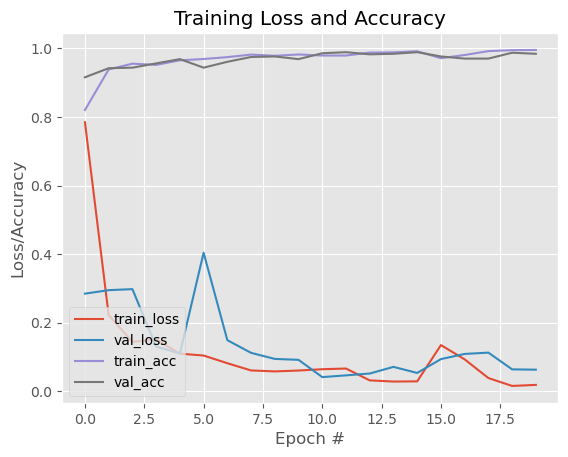

In [15]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")



In [18]:
# Assuming you have already trained your model and stored the training history in 'history'
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testX, testY)

# Print the test loss and test accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


21/21 [==============================] - 20s 960ms/step - loss: 0.0625 - accuracy: 0.9844
Test Loss: 0.06254588067531586
Test Accuracy: 0.9844236969947815


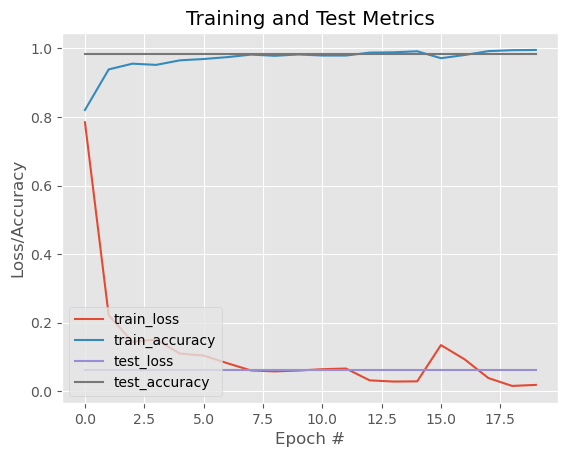

In [19]:
import matplotlib.pyplot as plt
import numpy as np

N = 20  # Adjust as needed
plt.style.use("ggplot")
plt.figure()

# Plot training loss and training accuracy
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")

# Plot test loss and test accuracy
test_loss = [0.06254588067531586] * N  # Replace with your test loss values
test_accuracy = [0.9844236969947815] * N  # Replace with your test accuracy values
plt.plot(np.arange(0, N), test_loss, label="test_loss")
plt.plot(np.arange(0, N), test_accuracy, label="test_accuracy")

plt.title("Training and Test Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()


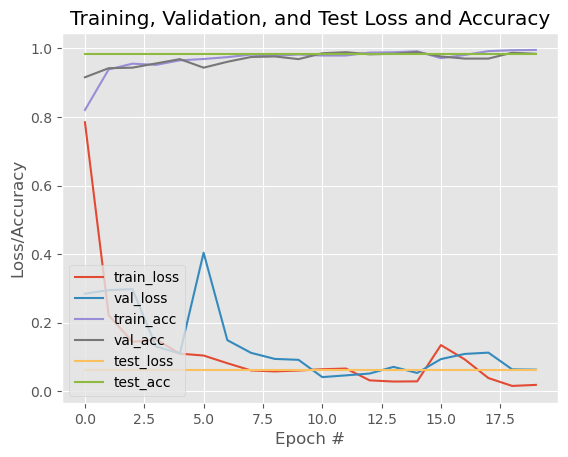

In [20]:
import matplotlib.pyplot as plt
import numpy as np

N = 20
plt.style.use("ggplot")
plt.figure()

# Plot training loss and validation loss
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

# Plot training accuracy and validation accuracy
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")

# Assuming you have test loss and test accuracy values available
# Plot test loss and test accuracy
test_loss = [0.06254588067531586] * N  # Replace with your test loss values
test_accuracy = [0.9844236969947815] * N  # Replace with your test accuracy values
plt.plot(np.arange(0, N), test_loss, label="test_loss")
plt.plot(np.arange(0, N), test_accuracy, label="test_acc")

plt.title("Training, Validation, and Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()


1/1 [==============================] - 1s 1s/step


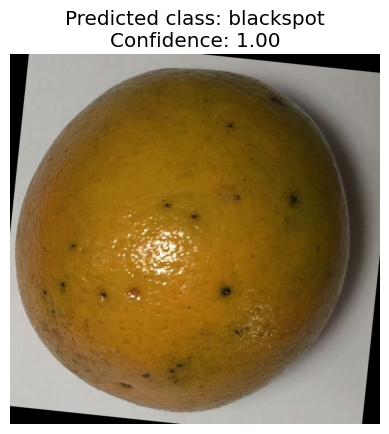

In [22]:
import tensorflow as tf
import numpy as np
import cv2  # For image preprocessing if needed
import matplotlib.pyplot as plt

# Load the saved model
model_path = "C:/Users/harshavardhanj/Desktop/Citrus/citrus_MobileNetV2.model"
model = tf.keras.models.load_model(model_path)

# Preprocess your input images (if required)
# For example, you may need to resize and normalize the images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Adjust the size as per your model's input size
    img = img / 255.0  # Normalize the pixel values
    return img

# Load and preprocess your test image(s)
image_path = "C:/Users/harshavardhanj/Desktop/Citrus/dataset/test/blackspot/pinta_preta_teste (5).jpg"
preprocessed_image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

# Interpret the predictions based on your model's output class labels
class_labels = ["blackspot", "canker", "fresh", "greening"]  # Replace with your class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

# Display the test image along with prediction info
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()


In [23]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def ImageNet_model(lr, shape, class_number):
    baseModel = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=shape))
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(class_number, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=lr), metrics=["accuracy"])

    return model


In [24]:
# Define and compile the model
model = ImageNet_model(lr, shape, class_number)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=lr), metrics=["accuracy"])

# Train the model
history = model.fit(trainX, trainY, batch_size=32, epochs=20, validation_data=(testX, testY))


219055592/219055592 [==============================] - 300s 1us/step


Epoch 1/20
81/81 [==============================] - 1665s 19s/step - loss: 0.4511 - accuracy: 0.8885 - val_loss: 11.5973 - val_accuracy: 0.4626
Epoch 2/20
63/81 [======================>.......] - ETA: 5:26 - loss: 0.0913 - accuracy: 0.9712

KeyboardInterrupt: 